In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import platform
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sklearn 
import cv2
import json
from glob import glob

https://www.kaggle.com/ayuraj/train-yolov5-cross-validation-ensemble-w-b

In [2]:
device = torch.device('cuda')

In [3]:
print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
print(f"- pytorch: {torch.__version__}")
print(f"- opencv: {cv2.__version__}")

- os: Windows-10-10.0.19041-SP0
- python: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
- pandas: 1.3.0
- numpy: 1.19.1
- sklearn: 1.0.2
- pytorch: 1.7.0
- opencv: 4.5.5


In [4]:
label_description = {
"1_00_0" : "딸기", 
"2_00_0" : "토마토",
"2_a5_2" : "토마토_흰가루병_중기",
"3_00_0" : "파프리카",
"3_a9_1" : "파프리카_흰가루병_초기",
"3_a9_2" : "파프리카_흰가루병_중기",
"3_a9_3" : "파프리카_흰가루병_말기",
"3_b3_1" : "파프리카_칼슘결핍_초기",
"3_b6_1" : "파프리카_다량원소결핍(N)_초기",
"3_b7_1" : "파프리카_다량원소결핍(P)_초기",
"3_b8_1" : "파프리카_다량원소결핍(K)_초기",
"4_00_0" : "오이",
"5_00_0" : "고추",
 "5_a7_2" : "고추_탄저병_중기",
 "5_b6_1" : "고추_다량원소결핍(N)_초기",
"5_b7_1" : "고추_다량원소결핍(P)_초기",
 "5_b8_1" : "고추_다량원소결핍(K)_초기",
"6_00_0" : "시설포도",
"6_a11_1" : "시설포도_탄저병_초기",
 "6_a11_2" : "시설포도_탄저병_중기",
 "6_a12_1" : "시설포도_노균병_초기",
"6_a12_2" : "시설포도_노균병_중기",
 "6_b4_1" : "시설포도_일소피해_초기",
 "6_b4_3" : "시설포도_일소피해_말기",
"6_b5_1" : "시설포도_축과병_초기"   }

# 1. 작물_부위 예측을 위한 라벨링

In [4]:
train_csv = sorted(glob('./_data/train/*/*.csv'))
train_jpg = sorted(glob('./_data/train/*/*.jpg'))
train_json = sorted(glob('./_data/train/*/*.json'))

test_csv = sorted(glob('./_data/test/*/*.csv'))
test_jpg = sorted(glob('./_data/test/*/*.jpg'))
test_json = sorted(glob('./_data/test/*/*.json'))

In [5]:
crop_dict = {1:'딸기', 
             2:'토마토',
             3:'파프리카',
             4:'오이', 
             5:'고추',
             6: '시설포도'}

area_dict = {1:'열매',
             2:'꽃',
             3:'잎',
             4:'가지',
             5:'줄기',
             6:'뿌리',
             7:'해충'}

task_dict = {0:'정상',
             1:'병해',
             2:'생리장애',
             3:'보호제처리반응'}

disease_dict = {'00' : '정상',
                
                # 병해 a
                'a1' : '딸기잿빛곰팡이병',
                'a2' : '딸기흰가루병',
                'a3' : '오이노균병',
                'a4' : '오이흰가루병',
                'a5' : '토마토흰가루병',
                'a6' : '토마토잿빛곰팡이병',
                'a7' : '고추탄저병',
                'a8' : '고추흰가루병',
                'a9' : '파프리카흰가루병',
                'a10' : '파프리카잘록병',
                'a11' : '시설포도탄저병',
                'a12' : '시설포도노균병',
                
                # 생리장애 b
                'b1' : '냉해피해',
                'b2' : '열과',
                'b3' : '칼슘결핍',
                'b4' : '일소피해',
                'b5' : '축과병',
                'b6' : '다량원소결핍 (N)',
                'b7' : '다량원소결핍 (P)',
                'b8' : '다량원소결핍 (K)',
                
                # 보호제 처리반응 c
                'c1' : '딸기잿빛곰팡이병반응',
                'c2' : '딸기흰가루병반응',
                'c3' : '오이노균병반응',
                'c4' : '오이흰가루병반응',
                'c5' : '토마토흰가루병반응',
                'c6' : '토마토잿빛곰팡이병반응',
                'c7' : '고추탄저병반응',
                'c8' : '고추흰가루병반응',
                'c9' : '파프리카흰가루병반응',
                'c10' : '파프리카잘록병반응',
                'c11' : '시설포도탄저병반응',
                'c12' : '시설포도노균병반응'
               }

            # 시설 과채류
grow_dict = {11:'유묘기',
             12:'생장기',
             13:'착화/과실기',
             
             # 시설 과수류 (포도)
             21:'발아기',
             22:'개화기',
             23:'신초생장기',
             24:'과실성숙기',
             25:'수확기',
             26:'휴면기'}

risk_dict = {0:'정상',
             1:'초기',
             2:'중기',
             3:'말기'}

In [6]:
def img_load(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (384, 512))
    return img

imgs = [img_load(k) for k in tqdm(train_jpg)]

100%|█████████████████████████████████████████████████████████████████████████████| 5767/5767 [00:39<00:00, 144.66it/s]


In [7]:
crops = []
areas = []
tasks = []
diseases = []
risks = []
grows = []
labels = []
dates = []
times = []
parts=[]
roi = []
for i in range(len(train_json)):
    with open(train_json[i], 'r') as f:
        sample = json.load(f)
        
        crop = sample['annotations']['crop']
        area = sample['annotations']['area']
        task = sample['description']['task']
        grow = sample['annotations']['grow']
        disease = sample['annotations']['disease']
        risk = sample['annotations']['risk']
        date = sample['description']['date']
        time = sample['description']['time']
        label=f"{crop}_{disease}_{risk}"        
        
        crops.append(crop)
        areas.append(area)
        tasks.append(task)
        grows.append(grow)
        diseases.append(disease)
        risks.append(risk)
        dates.append(date)
        times.append(time)
        labels.append(label)
        
        
        r = sample['annotations']['bbox'][0]
        temp = [int(r['x']), int(r['y']), int(r['w']), int(r['h'])]
        roi.append(temp)    
        
        p = []
        
        for part in sample['annotations']['part']:
            p.append({
                'bbox': [
                    int(part['x']), int(part['y']), int(part['w']), int(part['h'])
                ],
                'id': part['id']
            })
        parts.append(p)

In [8]:
# 병해부위 갯수
parts_i = [len(x) for x in parts]

In [9]:
data = pd.DataFrame({'crops':crops,'areas':areas,'tasks':tasks,'diseases':diseases,'risks':risks, 'grows':grows, 'labels':labels, 'dates':dates, 'times':times, 'parts':parts_i})
data

,crops,areas,tasks,diseases,risks,grows,labels,dates,times,parts
0,3,3,2,b7,1,13,3_b7_1,20211126,0935,2
1,3,5,0,00,0,11,3_00_0,20210914,0925,0
2,3,1,0,00,0,13,3_00_0,20210624,1332,0
3,3,3,0,00,0,11,3_00_0,20210915,1616,0
4,3,1,0,00,0,13,3_00_0,20210624,1430,0
...,...,...,...,...,...,...,...,...,...,...
5762,3,5,0,00,0,11,3_00_0,20210930,1234,0
5763,1,3,0,00,0,11,1_00_0,20210916,0952,0
5764,2,3,1,a5,2,12,2_a5_2,20211017,1249,1
5765,1,3,0,00,0,12,1_00_0,20211007,0956,0


In [11]:
data['crop_area'] = data.crops.apply(lambda x: str(x)) + data.areas.apply(lambda x: str(x))
print(data.crop_area.unique())

['33' '35' '31' '43' '13' '42' '53' '61' '63' '23' '51' '45' '21' '65'
 '32' '64']


# 작물 분포 확인

In [12]:
data_txt = data.copy()
data_txt.crops = data_txt.crops.apply(lambda x: crop_dict[x]+'('+ str(x) +')')
data_txt.areas = data_txt.areas.apply(lambda x: area_dict[x]+'('+ str(x) +')')
data_txt.tasks = data_txt.tasks.apply(lambda x: task_dict[x]+'('+ str(x) +')')
data_txt.diseases = data_txt.diseases.apply(lambda x: disease_dict[x]+'('+ str(x) +')')
data_txt.risks = data_txt.risks.apply(lambda x: risk_dict[x]+'('+ str(x) +')')
data_txt.grows = data_txt.grows.apply(lambda x: grow_dict[x]+'('+ str(x) +')')
data_txt.labels = data_txt.labels.apply(lambda x: crop_dict[int(x.split('_')[0])] + '_' + disease_dict[x.split('_')[1]] + '_' + risk_dict[int(x.split('_')[2])])
data_txt

,crops,areas,tasks,diseases,risks,grows,labels,dates,times,parts,crop_area
0,파프리카(3),잎(3),생리장애(2),다량원소결핍 (P)(b7),초기(1),착화/과실기(13),파프리카_다량원소결핍 (P)_초기,20211126,0935,2,33
1,파프리카(3),줄기(5),정상(0),정상(00),정상(0),유묘기(11),파프리카_정상_정상,20210914,0925,0,35
2,파프리카(3),열매(1),정상(0),정상(00),정상(0),착화/과실기(13),파프리카_정상_정상,20210624,1332,0,31
3,파프리카(3),잎(3),정상(0),정상(00),정상(0),유묘기(11),파프리카_정상_정상,20210915,1616,0,33
4,파프리카(3),열매(1),정상(0),정상(00),정상(0),착화/과실기(13),파프리카_정상_정상,20210624,1430,0,31
...,...,...,...,...,...,...,...,...,...,...,...
5762,파프리카(3),줄기(5),정상(0),정상(00),정상(0),유묘기(11),파프리카_정상_정상,20210930,1234,0,35
5763,딸기(1),잎(3),정상(0),정상(00),정상(0),유묘기(11),딸기_정상_정상,20210916,0952,0,13
5764,토마토(2),잎(3),병해(1),토마토흰가루병(a5),중기(2),생장기(12),토마토_토마토흰가루병_중기,20211017,1249,1,23
5765,딸기(1),잎(3),정상(0),정상(00),정상(0),생장기(12),딸기_정상_정상,20211007,0956,0,13


In [15]:
data_txt['crop_area'] = data.crops.apply(lambda x: crop_dict[x]) + '_' + data.areas.apply(lambda x: area_dict[x])
print(data_txt.crop_area.unique())

['파프리카_잎' '파프리카_줄기' '파프리카_열매' '오이_잎' '딸기_잎' '오이_꽃' '고추_잎' '시설포도_열매'
 '시설포도_잎' '토마토_잎' '고추_열매' '오이_줄기' '토마토_열매' '시설포도_줄기' '파프리카_꽃' '시설포도_가지']


In [21]:
crop_area_dict = {y:str(x) for x, y in enumerate(data_txt.crop_area.unique().tolist())}
crop_area_dict

{'파프리카_잎': '0',
 '파프리카_줄기': '1',
 '파프리카_열매': '2',
 '오이_잎': '3',
 '딸기_잎': '4',
 '오이_꽃': '5',
 '고추_잎': '6',
 '시설포도_열매': '7',
 '시설포도_잎': '8',
 '토마토_잎': '9',
 '고추_열매': '10',
 '오이_줄기': '11',
 '토마토_열매': '12',
 '시설포도_줄기': '13',
 '파프리카_꽃': '14',
 '시설포도_가지': '15'}

In [22]:
crop_area_dict = {y:str(x) for x, y in enumerate(data.crop_area.unique().tolist())}
crop_area_dict

{'33': '0',
 '35': '1',
 '31': '2',
 '43': '3',
 '13': '4',
 '42': '5',
 '53': '6',
 '61': '7',
 '63': '8',
 '23': '9',
 '51': '10',
 '45': '11',
 '21': '12',
 '65': '13',
 '32': '14',
 '64': '15'}

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5767 entries, 0 to 5766
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   crops     5767 non-null   int64 
 1   areas     5767 non-null   int64 
 2   tasks     5767 non-null   int64 
 3   diseases  5767 non-null   object
 4   risks     5767 non-null   int64 
 5   grows     5767 non-null   int64 
 6   labels    5767 non-null   object
 7   dates     5767 non-null   object
 8   times     5767 non-null   object
 9   parts     5767 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 450.7+ KB


In [13]:
import matplotlib
from matplotlib import font_manager, rc

font_path ="C:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
matplotlib.rc('font',family=font_name)

In [44]:
data.labels.unique()

array(['3_b7_1', '3_00_0', '4_00_0', '3_a9_1', '1_00_0', '3_b3_1',
       '5_b8_1', '3_b8_1', '5_b6_1', '3_b6_1', '6_00_0', '2_a5_2',
       '3_a9_2', '2_00_0', '5_a7_2', '5_b7_1', '3_a9_3', '6_b4_1',
       '5_00_0', '6_b4_3', '6_a11_1', '6_a12_1', '6_a12_2', '6_b5_1',
       '6_a11_2'], dtype=object)

# csv 데이터 확인

In [48]:
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

min_dict = {x:x+'_min' for x in csv_features}
max_dict = {x:x+'_max' for x in csv_features}

In [49]:
for i, d in enumerate(train_csv):
    _min = pd.read_csv(d)[csv_features].min(axis=0)
    _max = pd.read_csv(d)[csv_features].max(axis=0)
    _min.rename(min_dict, axis=1, inplace=True)
    _max.rename(max_dict, axis=1, inplace=True)
    data.loc[i,list(min_dict.values())] = _min
    data.loc[i,list(max_dict.values())] = _max

# 훈련 데이터 shape 확인

In [50]:
temp_dict = {}
for i in range(len(imgs)):
    try:
        temp_dict[str(imgs[i].shape)] += 1
    except:
        temp_dict[str(imgs[i].shape)] = 1

In [51]:
temp_dict

{'(512, 384, 3)': 3349,
 '(512, 682, 3)': 2000,
 '(512, 740, 3)': 51,
 '(512, 242, 3)': 246,
 '(512, 262, 3)': 68,
 '(512, 622, 3)': 14,
 '(512, 512, 3)': 25,
 '(512, 1081, 3)': 14}

# yolov5 annotation 생성
* class x_center, y_center, w, h
* 512,384 가 많으므로 해당 크기로 이미지 리사이즈 및 좌표 변환

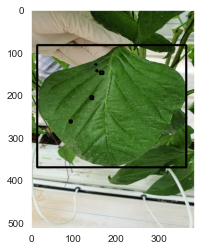

In [15]:
# IMG_WIDTH = 384
# IMG_HEIGHT = 512

# # 이미지 크기 변경, 좌표 잘 변환됐는지 확인하기 위해 이미지로 확인
# for i in range(1):
#     i=342
#     temp_img = cv2.resize(imgs[i], (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
#     x1,y1,w,h = roi[i]
#     x2, y2 = x1+w, y1+h
#     x1, y1, x2, y2 = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], x2*IMG_WIDTH//imgs[i].shape[1], y2*IMG_HEIGHT//imgs[i].shape[0]
#     cv2.rectangle(temp_img, (x1, y1), (x2, y2), (0,0,0), 3)
            
#     for j in parts[i]:
#         x1,y1,w,h = j['bbox']
#         x2, y2 = x1+w, y1+h
#         x1, y1, x2, y2 = x1*384//imgs[i].shape[1], y1*512//imgs[i].shape[0], x2*384//imgs[i].shape[1], y2*512//imgs[i].shape[0] 
#         cv2.rectangle(temp_img, (x1, y1), (x2, y2), (0,0,0), 3)
# plt.imshow(temp_img)

# 검증용 데이터 분류
## 작물 별 데이터 비율을 일정하게 유지하기 위해 crop을 기준으로 나누었음.

In [16]:
x = data.drop(columns=['crops'])
y = data['crops']

In [17]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [18]:
train_dataset = pd.concat([y_train,x_train], axis=1)
train_dataset

,crops,areas,tasks,diseases,risks,grows,labels,dates,times,parts
4298,5,3,0,00,0,12,5_00_0,20211018,1430,0
628,3,1,0,00,0,13,3_00_0,20210624,1029,0
1517,6,3,0,00,0,24,6_00_0,20210617,0942,0
3905,3,3,2,b8,1,13,3_b8_1,20211103,0957,4
2299,5,1,1,a7,2,13,5_a7_2,20210806,1703,2
...,...,...,...,...,...,...,...,...,...,...
4511,3,3,0,00,0,12,3_00_0,20210924,1154,0
1777,3,5,0,00,0,11,3_00_0,20210915,1701,0
3280,1,3,0,00,0,11,1_00_0,20210916,1758,0
408,6,3,0,00,0,24,6_00_0,20210628,1129,0


In [19]:
val_dataset = pd.concat([y_test,x_test], axis=1)
val_dataset

,crops,areas,tasks,diseases,risks,grows,labels,dates,times,parts
2713,6,1,1,a11,2,24,6_a11_2,20210830,1515,18
4909,1,3,0,00,0,11,1_00_0,20210916,1015,0
906,1,3,0,00,0,11,1_00_0,20210916,0948,0
4170,3,3,1,a9,3,13,3_a9_3,20210706,0937,32
3870,1,3,0,00,0,11,1_00_0,20210928,1024,0
...,...,...,...,...,...,...,...,...,...,...
3622,3,3,1,a9,2,13,3_a9_2,20210622,1440,31
2080,3,5,0,00,0,11,3_00_0,20210915,1556,0
1100,4,3,0,00,0,13,4_00_0,20211001,1038,0
5468,6,1,1,a11,2,24,6_a11_2,20210830,1520,6


In [20]:
val_index= val_dataset.index.tolist()

# 리사이즈 이미지 및 변환 annotations 저장

In [41]:
IMG_WIDTH = 384
IMG_HEIGHT = 512

for i, img_path in enumerate(train_jpg):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)

    if i in val_index:
        dataset_dir = 'val_data'
    else:
        dataset_dir = 'train_data'
        
    cv2.imwrite(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/images/{i}.jpg', img)
    x1,y1,w,h = roi[i]
    x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]
    
    txt_dir = train_jpg[i].replace('.jpg', '.txt')

    with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}.txt', 'w') as f:
        #if data.loc[i].disease_label==0:
        x_center, y_center, w, h = (x+w/2)/IMG_WIDTH, (y+h/2)/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
        s = str(l_dict[data.labels[i]]) + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
        f.write(s)

        # 병해부위 parts도 annotation 생성할지..
#         for j in parts[i]:
#             x1,y1,w,h = j['bbox']
# #             x2, y2 = x1+w, y1+h
# #             x1, y1, x2, y2 = x1*384//imgs[i].shape[1], y1*512//imgs[i].shape[0], x2*384//imgs[i].shape[1], y2*512//imgs[i].shape[0]
#             x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]

#              #yolov5용 좌표
#             x_center, y_center, w, h = (x+w/2)/IMG_WIDTH, (y+h/2)/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
#             s = str(data.loc[i].disease_label) + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
#             f.write(s)
            

In [ ]:
for i, img_path in enumerate(train_jpg[0]):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
    img_flip0 = cv2.flip(img, 0)
    img_flip1 = cv2.flip(img, 1)

    if i in val_index:
        dataset_dir = 'val_data'
    else:
        dataset_dir = 'train_data'
        
    #cv2.imwrite(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/images/{i}.jpg', img)
    x1,y1,w,h = roi[i]
    x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]
#     
#     txt_dir = train_jpg[i].replace('.jpg', '.txt')

#     with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}.txt', 'w') as f:
#         #if data.loc[i].disease_label==0:
#         x_center, y_center, w, h = (x+w/2)/IMG_WIDTH, (y+h/2)/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
#         s = str(l_dict[data.labels[i]]) + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
#         f.write(s)

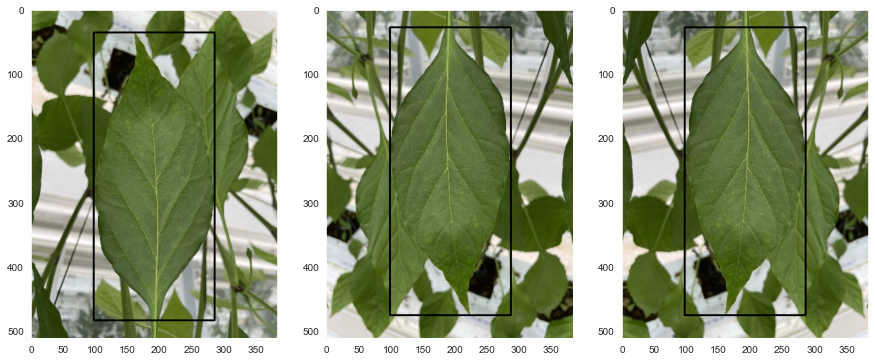

In [16]:
# 이미지 크기 변경, 좌표 잘 변환됐는지 확인하기 위해 이미지로 확인
IMG_WIDTH = 384
IMG_HEIGHT = 512

f, ax = plt.subplots(1,3, figsize=(15,15))

for i in range(1):
    i=1124
    temp_img = cv2.resize(imgs[i], (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)
    img_flip0 = cv2.flip(temp_img, 0) #상하대칭
    img_flip1 = cv2.flip(temp_img, 1) #좌우대칭

    x1,y1,w,h = roi[i]
    x2, y2 = x1+w, y1+h
    x1, y1, x2, y2 = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], x2*IMG_WIDTH//imgs[i].shape[1], y2*IMG_HEIGHT//imgs[i].shape[0]
    cv2.rectangle(temp_img, (x1, y1), (x2, y2), (0,0,0), 2)
    
    # 상하대칭 좌표 변환
    x1,y1,w,h = roi[i]
    x2, y2 = x1+w, y1+h
    x1, y1, x2, y2 = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], x2*IMG_WIDTH//imgs[i].shape[1], y2*IMG_HEIGHT//imgs[i].shape[0]
    y1, y2 = IMG_HEIGHT-y1, IMG_HEIGHT-y2
    cv2.rectangle(img_flip0, (x1, y1), (x2, y2), (0,0,0), 2)
    
    # 좌우대칭 좌표 변환
    x1,y1,w,h = roi[i]
    x2, y2 = x1+w, y1+h
    x1, y1, x2, y2 = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], x2*IMG_WIDTH//imgs[i].shape[1], y2*IMG_HEIGHT//imgs[i].shape[0]
    x1, x2 = IMG_WIDTH - x1, IMG_WIDTH - x2
    cv2.rectangle(img_flip1, (x1, y1), (x2, y2), (0,0,0), 2)    
    
    ax[0].imshow(img_flip0)
    ax[1].imshow(img_flip1)
    ax[2].imshow(temp_img)
plt.show()

# 좌우/상하대칭 이미지 및 annotations 저장

In [ ]:
IMG_WIDTH = 384
IMG_HEIGHT = 512

for i, img_path in enumerate(train_jpg):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)

    if i in val_index:
        dataset_dir = 'val_data_augm'
    else:
        dataset_dir = 'train_data_augm'
    
    # 이미지 저장
    cv2.imwrite(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/images/{i}.jpg', img)
    
    # 상하대칭 이미지 
    cv2.imwrite(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/images/{i}_flip0.jpg', cv2.flip(img, 0))
    
    # 좌우대칭 이미지 
    cv2.imwrite(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/images/{i}_flip1.jpg', cv2.flip(img, 1))
    
    # 좌표 변환
    x1,y1,w,h = roi[i]
    x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]
        
    # 이미지에 대한 좌표 저장
    txt_dir = train_jpg[i].replace('.jpg', '.txt')
    
    with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}.txt', 'w') as f:
        #if data.loc[i].disease_label==0:
        x_center, y_center, w, h = (x+w/2)/IMG_WIDTH, (y+h/2)/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
        s = str(l_dict[data.labels[i]]) + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
        f.write(s)
    
    with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}_flip0.txt', 'w') as f:
        #if data.loc[i].disease_label==0:
        x_center, y_center, w, h = (x+w/2)/IMG_WIDTH, (IMG_HEIGHT-(y+h/2))/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
        s = str(l_dict[data.labels[i]]) + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
        f.write(s)
        
    with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}_flip1.txt', 'w') as f:
        #if data.loc[i].disease_label==0:
        x_center, y_center, w, h = (IMG_WIDTH-(x+w/2))/IMG_WIDTH, (y+h/2)/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
        s = str(l_dict[data.labels[i]]) + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
        f.write(s)
    

        
        # 병해부위 parts도 annotation 생성할지..
#         for j in parts[i]:
#             x1,y1,w,h = j['bbox']
# #             x2, y2 = x1+w, y1+h
# #             x1, y1, x2, y2 = x1*384//imgs[i].shape[1], y1*512//imgs[i].shape[0], x2*384//imgs[i].shape[1], y2*512//imgs[i].shape[0]
#             x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]

#              #yolov5용 좌표
#             x_center, y_center, w, h = (x+w/2)/IMG_WIDTH, (y+h/2)/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
#             s = str(data.loc[i].disease_label) + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
#             f.write(s)
            

1. crop_area로 라벨링

In [26]:
x = data.drop(columns=['crops'])
y = data['crops']

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
train_dataset = pd.concat([y_train,x_train], axis=1)
val_dataset = pd.concat([y_test,x_test], axis=1)
val_index= val_dataset.index.tolist()

IMG_WIDTH = 384
IMG_HEIGHT = 512

for i, img_path in enumerate(train_jpg):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)

    if i in val_index:
        dataset_dir = 'val_data_augm'
    else:
        dataset_dir = 'train_data_augm'
    
    # 이미지 저장
    cv2.imwrite(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/images/{i}.jpg', img)
    
    # 상하대칭 이미지 
    cv2.imwrite(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/images/{i}_flip0.jpg', cv2.flip(img, 0))
    
    # 좌우대칭 이미지 
    cv2.imwrite(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/images/{i}_flip1.jpg', cv2.flip(img, 1))
    
    # 좌표 변환
    x1,y1,w,h = roi[i]
    x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]
        
    # 이미지에 대한 좌표 저장
    txt_dir = train_jpg[i].replace('.jpg', '.txt')
    
    with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}.txt', 'w') as f:
        #if data.loc[i].disease_label==0:
        x_center, y_center, w, h = (x+w/2)/IMG_WIDTH, (y+h/2)/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
        s = str(crop_area_dict[data.crop_area[i]]) + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
        f.write(s)
        
    # 상하대칭 이미지 
    with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}_flip0.txt', 'w') as f:
        #if data.loc[i].disease_label==0:
        y_center_flip =(IMG_HEIGHT-(y+h/2))/IMG_HEIGHT
        s = str(crop_area_dict[data.crop_area[i]]) + ' ' + str(x_center)+ ' ' + str(y_center_flip)+ ' ' + str(w)+ ' ' + str(h) + '\n'
        f.write(s)
    
    # 좌우대칭 이미지 
    with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}_flip1.txt', 'w') as f:
        #if data.loc[i].disease_label==0:
        x_center_flip = (IMG_WIDTH-(x+w/2))/IMG_WIDTH
        s = str(crop_area_dict[data.crop_area[i]]) + ' ' + str(x_center_flip)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
        f.write(s)


        
        # 병해부위 parts도 annotation 생성할지..
#         for j in parts[i]:
#             x1,y1,w,h = j['bbox']
# #             x2, y2 = x1+w, y1+h
# #             x1, y1, x2, y2 = x1*384//imgs[i].shape[1], y1*512//imgs[i].shape[0], x2*384//imgs[i].shape[1], y2*512//imgs[i].shape[0]
#             x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]

#              #yolov5용 좌표
#             x_center, y_center, w, h = (x+w/2)/IMG_WIDTH, (y+h/2)/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
#             s = str(data.loc[i].disease_label) + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
#             f.write(s)
            

# 2. 병해 parts만 annotation 생성
*_augm/images는 그대로 사용, label만 새로

In [30]:
diseases_d = {'00' : '정상',
            
            'a1' : '잿빛곰팡이병',
            'a2' : '흰가루병',
            'a3' : '노균병',
            'a4' : '흰가루병',
            'a5' : '흰가루병',
            'a6' : '잿빛곰팡이병',
            'a7' : '탄저병',
            'a8' : '흰가루병',
            'a9' : '흰가루병',
            'a10' : '잘록병',
            'a11' : '탄저병',
            'a12' : '노균병',
                
            # 생리장애 b
            'b1' : '냉해피해',
            'b2' : '열과',
            'b3' : '칼슘결핍',
            'b4' : '일소피해',
            'b5' : '축과병',
            'b6' : '다량원소결핍 (N)',
            'b7' : '다량원소결핍 (P)',
            'b8' : '다량원소결핍 (K)' 
            }


병마다 증상이 나타나는 위치는 모두 하나밖에 없음.

In [81]:
for a in data.diseases.unique():
    print(f'{a}: {data_txt[(data.diseases==a)].areas.unique()}')

b7: ['잎(3)']
00: ['줄기(5)' '열매(1)' '잎(3)' '꽃(2)' '가지(4)']
a9: ['잎(3)']
b3: ['잎(3)']
b8: ['잎(3)']
b6: ['잎(3)']
a5: ['잎(3)']
a7: ['열매(1)']
b4: ['잎(3)']
a11: ['열매(1)']
a12: ['잎(3)']
b5: ['열매(1)']


# 정상 이외의 데이터만 이미지 저장 및 anntation 작성

In [32]:
diseases_df = data.copy()

In [35]:
diseases_df.loc[diseases_df.disease_label=='정상', 'disease_label'] = np.nan
diseases_df = diseases_df.dropna(axis=0)
diseases_df

,crops,areas,tasks,diseases,risks,grows,labels,dates,times,parts,crop_area,disease_label
0,3,3,2,b7,1,13,3_b7_1,20211126,0935,2,33,다량원소결핍 (P)
5,3,3,2,b7,1,13,3_b7_1,20211126,0936,2,33,다량원소결핍 (P)
6,3,3,2,b7,1,13,3_b7_1,20211125,0922,4,33,다량원소결핍 (P)
9,3,3,1,a9,1,13,3_a9_1,20210622,1059,1,33,흰가루병
12,3,3,2,b3,1,13,3_b3_1,20211102,1224,4,33,칼슘결핍
...,...,...,...,...,...,...,...,...,...,...,...,...
5754,5,1,1,a7,2,13,5_a7_2,20210811,1726,1,51,탄저병
5759,5,1,1,a7,2,13,5_a7_2,20210810,1718,1,51,탄저병
5761,3,3,2,b6,1,13,3_b6_1,20211102,1618,1,33,다량원소결핍 (N)
5764,2,3,1,a5,2,12,2_a5_2,20211017,1249,1,23,흰가루병


In [83]:
diseases_df['disease_risk_label'] = diseases_df.disease_label + diseases_df.risks.apply(lambda x: str(x))
diseases_df['disease_risk_label']

0       다량원소결핍 (P)1
5       다량원소결핍 (P)1
6       다량원소결핍 (P)1
9             흰가루병1
12            칼슘결핍1
           ...     
5754           탄저병2
5759           탄저병2
5761    다량원소결핍 (N)1
5764          흰가루병2
5766    다량원소결핍 (N)1
Name: disease_risk_label, Length: 1823, dtype: object

In [84]:
diseases_df['disease_risk_label'].unique()

array(['다량원소결핍 (P)1', '흰가루병1', '칼슘결핍1', '다량원소결핍 (K)1', '다량원소결핍 (N)1',
       '흰가루병2', '탄저병2', '흰가루병3', '일소피해1', '일소피해3', '탄저병1', '노균병1', '노균병2',
       '축과병1'], dtype=object)

In [85]:
disease_label_dict = {y:str(x) for x, y in enumerate(diseases_df.disease_risk_label.unique())}
disease_label_dict

{'다량원소결핍 (P)1': '0',
 '흰가루병1': '1',
 '칼슘결핍1': '2',
 '다량원소결핍 (K)1': '3',
 '다량원소결핍 (N)1': '4',
 '흰가루병2': '5',
 '탄저병2': '6',
 '흰가루병3': '7',
 '일소피해1': '8',
 '일소피해3': '9',
 '탄저병1': '10',
 '노균병1': '11',
 '노균병2': '12',
 '축과병1': '13'}

In [37]:
x = diseases_df.drop(columns=['crops'])
y = diseases_df['crops']

x_train,x_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
train_dataset = pd.concat([y_train,x_train], axis=1)
val_dataset = pd.concat([y_test,x_test], axis=1)
val_index= val_dataset.index.tolist()

In [42]:
train_index= train_dataset.index.tolist()

In [39]:
len(val_index)

365

In [46]:
disease_dirs = [(i, x) for i, x in enumerate(train_jpg) if i in val_index+train_index]
disease_dirs

[(0, './_data/train\\10027\\10027.jpg'),
 (5, './_data/train\\10090\\10090.jpg'),
 (6, './_data/train\\10109\\10109.jpg'),
 (9, './_data/train\\10118\\10118.jpg'),
 (12, './_data/train\\10173\\10173.jpg'),
 (13, './_data/train\\10192\\10192.jpg'),
 (14, './_data/train\\10199\\10199.jpg'),
 (18, './_data/train\\10238\\10238.jpg'),
 (19, './_data/train\\10251\\10251.jpg'),
 (20, './_data/train\\10252\\10252.jpg'),
 (21, './_data/train\\10263\\10263.jpg'),
 (24, './_data/train\\10300\\10300.jpg'),
 (26, './_data/train\\10323\\10323.jpg'),
 (27, './_data/train\\10328\\10328.jpg'),
 (30, './_data/train\\10365\\10365.jpg'),
 (35, './_data/train\\10442\\10442.jpg'),
 (36, './_data/train\\10462\\10462.jpg'),
 (38, './_data/train\\10480\\10480.jpg'),
 (40, './_data/train\\10505\\10505.jpg'),
 (47, './_data/train\\10549\\10549.jpg'),
 (51, './_data/train\\10649\\10649.jpg'),
 (52, './_data/train\\10652\\10652.jpg'),
 (55, './_data/train\\10682\\10682.jpg'),
 (56, './_data/train\\10693\\10693.jpg

In [44]:
len(disease_dirs)

1823

In [87]:
for i, img_path in disease_dirs:
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)

    if i in val_index:
        dataset_dir = 'disease_val'
    else:
        dataset_dir = 'disease_train'
    
    # 이미지 저장
    cv2.imwrite(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/images/{i}.jpg', img)
    
    # 상하대칭 이미지 
    cv2.imwrite(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/images/{i}_flip0.jpg', cv2.flip(img, 0))
    
    # 좌우대칭 이미지 
    cv2.imwrite(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/images/{i}_flip1.jpg', cv2.flip(img, 1))
    
    # 좌표 변환
    x1,y1,w,h = roi[i]
    x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]
        
    # 이미지에 대한 좌표 저장
    txt_dir = train_jpg[i].replace('.jpg', '.txt')
    
    
#     with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}.txt', 'w') as f:
#         #if data.loc[i].disease_label==0:
#         x_center, y_center, w, h = (x+w/2)/IMG_WIDTH, (y+h/2)/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
#         s = str(crop_area_dict[data.crop_area[i]]) + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
#         f.write(s)
        
#     # 상하대칭 이미지 
#     with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}_flip0.txt', 'w') as f:
#         #if data.loc[i].disease_label==0:
#         y_center_flip =(IMG_HEIGHT-(y+h/2))/IMG_HEIGHT
#         s = str(crop_area_dict[data.crop_area[i]]) + ' ' + str(x_center)+ ' ' + str(y_center_flip)+ ' ' + str(w)+ ' ' + str(h) + '\n'
#         f.write(s)
    
#     # 좌우대칭 이미지 
#     with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}_flip1.txt', 'w') as f:
#         #if data.loc[i].disease_label==0:
#         x_center_flip = (IMG_WIDTH-(x+w/2))/IMG_WIDTH
#         s = str(crop_area_dict[data.crop_area[i]]) + ' ' + str(x_center_flip)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
#         f.write(s)
    
    # 리사이즈 이미지
    with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}.txt', 'w') as f:

        for j in parts[i]:
            x1,y1,w,h = j['bbox']
            x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]

            #yolov5용 좌표
            x_center, y_center, w, h = (x+w/2)/IMG_WIDTH, (y+h/2)/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
            s = disease_label_dict[diseases_df.disease_risk_label[i]] + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
            f.write(s)
    
    # flip 0 
    with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}_flip0.txt', 'w') as f:

        for j in parts[i]:
            x1,y1,w,h = j['bbox']
            x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]

            #yolov5용 좌표 flip0
            x_center, y_center, w, h = (x+w/2)/IMG_WIDTH, (IMG_HEIGHT-(y+h/2))/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
            s = disease_label_dict[diseases_df.disease_risk_label[i]] + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
            f.write(s)
    
    # flip 1
    with open(f'C:/git/jonie_github/VISION/_data/{dataset_dir}/labels/{i}_flip1.txt', 'w') as f:

        for j in parts[i]:
            x1,y1,w,h = j['bbox']
            x, y, w, h = x1*IMG_WIDTH//imgs[i].shape[1], y1*IMG_HEIGHT//imgs[i].shape[0], w*IMG_WIDTH//imgs[i].shape[1], h*IMG_HEIGHT//imgs[i].shape[0]

            #yolov5용 좌표 flip0
            x_center, y_center, w, h = (IMG_WIDTH-(x+w/2))/IMG_WIDTH, (y+h/2)/IMG_HEIGHT, w/IMG_WIDTH, h/IMG_HEIGHT
            s = disease_label_dict[diseases_df.disease_risk_label[i]] + ' ' + str(x_center)+ ' ' + str(y_center)+ ' ' + str(w)+ ' ' + str(h) + '\n'
            f.write(s)